In [5]:
#import required libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import IsolationForest 
from ucimlrepo import fetch_ucirepo

In [3]:
!pip install ucimlrepo

In [24]:
#load the dataset
air_quality = fetch_ucirepo(id=360) # air Quality dataset

In [7]:
air_quality

{'data': {'ids': None,
  'features':            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
  0     3/10/2004  18:00:00     2.6         1360       150      11.9   
  1     3/10/2004  19:00:00     2.0         1292       112       9.4   
  2     3/10/2004  20:00:00     2.2         1402        88       9.0   
  3     3/10/2004  21:00:00     2.2         1376        80       9.2   
  4     3/10/2004  22:00:00     1.6         1272        51       6.5   
  ...         ...       ...     ...          ...       ...       ...   
  9352   4/4/2005  10:00:00     3.1         1314      -200      13.5   
  9353   4/4/2005  11:00:00     2.4         1163      -200      11.4   
  9354   4/4/2005  12:00:00     2.4         1142      -200      12.4   
  9355   4/4/2005  13:00:00     2.1         1003      -200       9.5   
  9356   4/4/2005  14:00:00     2.2         1071      -200      11.9   
  
        PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
  0              1046      

In [10]:
df = air_quality.data.features

In [12]:
#Select the specific columns for anomaly detection 
features = df[['CO(GT)', 'C6H6(GT)','NOx(GT)','NO2(GT)']]
features.head()

,CO(GT),C6H6(GT),NOx(GT),NO2(GT)
0,2.6,11.9,166,113
1,2.0,9.4,103,92
2,2.2,9.0,131,114
3,2.2,9.2,172,122
4,1.6,6.5,131,116


In [13]:
features.isnull().sum()

CO(GT)      0
C6H6(GT)    0
NOx(GT)     0
NO2(GT)     0
dtype: int64

In [15]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CO(GT)    9357 non-null   float64
 1   C6H6(GT)  9357 non-null   float64
 2   NOx(GT)   9357 non-null   int64  
 3   NO2(GT)   9357 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 292.5 KB


In [16]:
# parameters for isolation forest
n_estimators = 100 #number of trees in the forest
contamination = 0.01 #proportion of outliers in the data
sample_size = 256 #number of samples to draw from the data to train each tree

In [19]:
# train the isolation forest model
model = IsolationForest(n_estimators=n_estimators, contamination=contamination,
max_samples=sample_size, random_state=42)
model.fit(features)

# predict anomalies
anomaly_labels = model.predict(features) #-1 for anomalies, 1 for normal instances

anomaly_labels

array([1, 1, 1, ..., 1, 1, 1])

In [20]:
#create new column in the original dataframe to store anomaly labels
features['anomaly' ] = anomaly_labels
features.head()

C:\Users\prabh\AppData\Local\Temp\ipykernel_29508\2402546739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['anomaly' ] = anomaly_labels


,CO(GT),C6H6(GT),NOx(GT),NO2(GT),anomaly
0,2.6,11.9,166,113,1
1,2.0,9.4,103,92,1
2,2.2,9.0,131,114,1
3,2.2,9.2,172,122,1
4,1.6,6.5,131,116,1


In [23]:
features['anomaly'].value_counts()

anomaly
 1    9263
-1      94
Name: count, dtype: int64

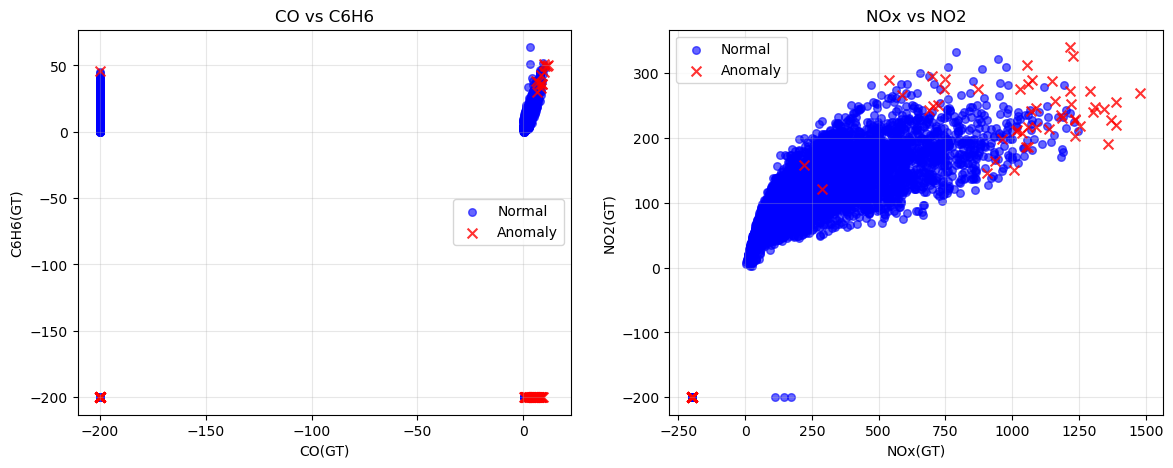

Normal data points: 9263
Anomalies detected: 94


In [28]:
# Visualize anomalies - Multiple feature comparisons
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

normal = features[features['anomaly' ] == 1]
anomaly = features[features['anomaly' ] == -1]

# Plot 1: CO vs C6H6
axes[0].scatter(normal['CO(GT)'], normal['C6H6(GT)'], color='blue', label='Normal', alpha=0.6, s=30)
axes[0].scatter(anomaly['CO(GT)'], anomaly['C6H6(GT)'], color='red', label='Anomaly', alpha=0.8, s=50, marker='x' )
axes[0].set_xlabel('CO(GT)')
axes[0].set_ylabel('C6H6(GT)')
axes[0].set_title('CO vs C6H6')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: NOx vs NO2
axes[1].scatter(normal['NOx(GT)'], normal['NO2(GT)'], color='blue', label='Normal', alpha=0.6, s=30)
axes[1].scatter(anomaly['NOx(GT)'], anomaly['NO2(GT)'], color='red', label='Anomaly', alpha=0.8, s=50, marker='x' )
axes[1].set_xlabel('NOx(GT)')
axes[1].set_ylabel('NO2(GT)')
axes[1].set_title('NOx vs NO2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()
print(f"Normal data points: {len(normal)}")
print(f"Anomalies detected: {len(anomaly)}")


c:\Users\prabh\anaconda3\Lib\site-packages\matplotlib\collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


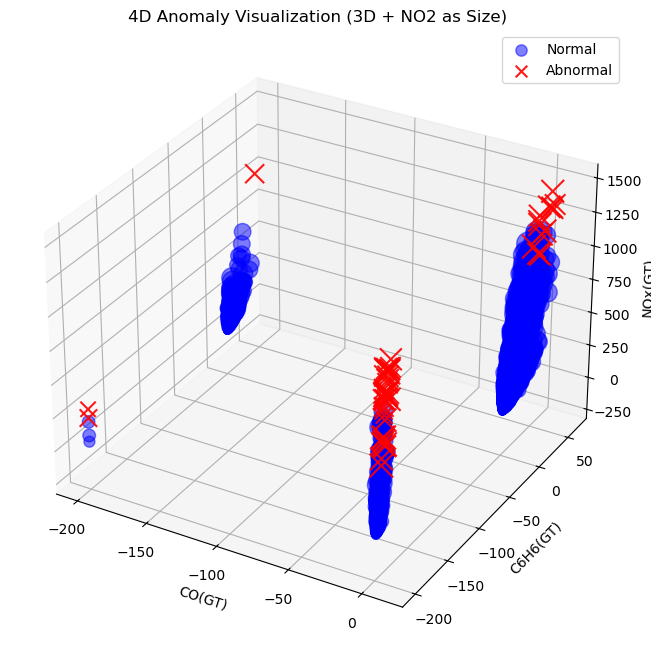

Normal points: 9263
Abnormal points: 94


In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Split data
normal = features[features['anomaly'] == 1]
abnormal = features[features['anomaly'] == -1]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Normal points (Blue)
ax.scatter(
    normal['CO(GT)'],
    normal['C6H6(GT)'],
    normal['NOx(GT)'],
    c='blue',
    alpha=0.5,
    s=normal['NO2(GT)'],   # 4th dimension via size
    label='Normal'
)

# Abnormal points (Red)
ax.scatter(
    abnormal['CO(GT)'],
    abnormal['C6H6(GT)'],
    abnormal['NOx(GT)'],
    c='red',
    alpha=0.9,
    s=abnormal['NO2(GT)'],
    marker='x',
    label='Abnormal'
)

ax.set_xlabel('CO(GT)')
ax.set_ylabel('C6H6(GT)')
ax.set_zlabel('NOx(GT)')
ax.set_title('4D Anomaly Visualization (3D + NO2 as Size)')
ax.legend()

plt.show()

print(f"Normal points: {len(normal)}")
print(f"Abnormal points: {len(abnormal)}")


In [35]:
import plotly.graph_objects as go
import numpy as np
 
# Separate normal and anomaly
normal = features[features['anomaly'] == 1]
anomaly = features[features['anomaly'] == -1]
 
fig = go.Figure()
 
# Normal points
fig.add_trace(go.Scatter3d(
    x=normal['CO(GT)'],
    y=normal['C6H6(GT)'],
    z=normal['NOx(GT)'],
    mode='markers',
    name='Normal',
    marker=dict(
        size=6,
        color=normal['NO2(GT)'],   # 4th dimension as color
        colorscale='Blues',
        opacity=0.6,
        colorbar=dict(title='NO2(GT)')
    )
))
 
# Anomaly points
fig.add_trace(go.Scatter3d(
    x=anomaly['CO(GT)'],
    y=anomaly['C6H6(GT)'],
    z=anomaly['NOx(GT)'],
    mode='markers',
    name='Anomaly',
    marker=dict(
        size=8,
        color=anomaly['NO2(GT)'],
        colorscale='Reds',
        opacity=0.9,
        symbol='diamond'
    )
))
 
# Layout
fig.update_layout(
    title='4D Scatter Plot (Color = NO2(GT))',
    scene=dict(
        xaxis_title='CO(GT)',
        yaxis_title='C6H6(GT)',
        zaxis_title='NOx(GT)'
    ),
    width=900,
    height=700
)
 
fig.show()
 